<a href="https://www.kaggle.com/code/aadikabhatia/sentimentanalysistwitter?scriptVersionId=130933607" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import re
import string

import seaborn as sns 
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=DATASET_COLUMNS)

In [5]:
df.sample(6)

,target,ids,date,flag,user,text
58651,0,1685947907,Sun May 03 02:56:16 PDT 2009,NO_QUERY,TwinkyImp,why does the sun shine on a weekend? - the bea...
1030382,4,1932914569,Tue May 26 22:31:26 PDT 2009,NO_QUERY,elijahsnowphoto,Will be posting some pics tonight!
551777,0,2203247770,Tue Jun 16 23:19:44 PDT 2009,NO_QUERY,_CamilleN,@elliotminor http://twitpic.com/7jqgw - Can't ...
401493,0,2057689936,Sat Jun 06 13:28:44 PDT 2009,NO_QUERY,metax,Can't damned Microsoft hurry up and release th...
1044116,4,1957403566,Fri May 29 00:23:39 PDT 2009,NO_QUERY,SarahHorvat,@trekkerguy If you say so It's all good
1014490,4,1881440529,Fri May 22 04:40:16 PDT 2009,NO_QUERY,huchick2006,@THICKDECADENCE nope...chilling at home!


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df.nunique()

target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

In [8]:
df = df[["target","text"]]
df.sample(5)

,target,text
1206779,4,"after pizza, time for a little reeding and th..."
232022,0,The power just went out!
652435,0,is absolutely bored and her internet keeps mes...
1079865,4,Just got done with a 2 hour work out. Burned o...
1157736,4,@mustntgrumble Oh good luck with the ironing ...


In [9]:
df.target.unique()

array([0, 4])

In [10]:
df.target = df['target'].replace(4,1)

In [11]:
df.target.unique()

array([0, 1])

In [12]:
df.sample(5)

,target,text
1209351,1,Weather is lovely again on my way to college!
1177864,1,@esoterismo You're quite welcome
234174,0,"Had a great bike ride yesterday, was looking f..."
896641,1,The wedding was beautiful and amazingly fun! ....
1169555,1,@ddlovato haha we watched that last night too ...


In [13]:
df.shape

(1600000, 2)

In [14]:
df['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

Negative    800000
Positive    800000
Name: target, dtype: int64


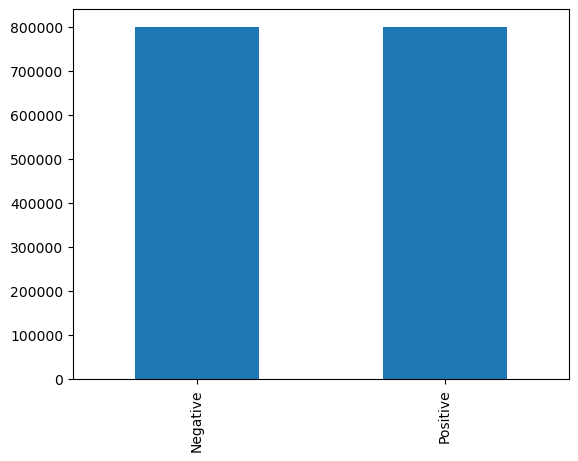

In [15]:
sentiment= {0:'Negative', 1:'Positive'}
print(df['target'].apply(lambda x: sentiment[x]).value_counts())
df['target'].apply(lambda x: sentiment[x]).value_counts().plot(kind='bar')
plt.show()

In [16]:
data =  df[["text", 'target']]
data.head(2)

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0


<Axes: >

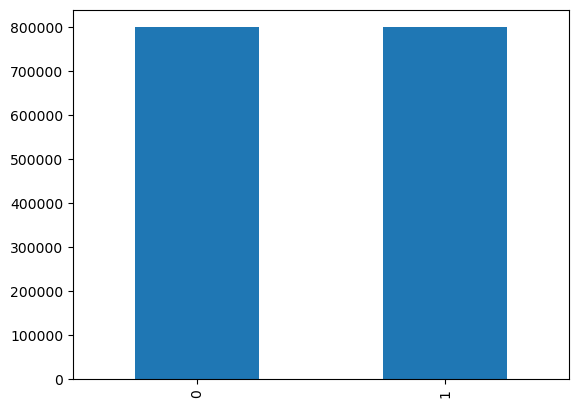

In [17]:
df['target'].value_counts().plot(kind='bar')

In [18]:
data_pos = data[data['target']==1].sample(50000, random_state=42)
data_neg = data[data['target']==0].sample(50000, random_state=42)

dataset = pd.concat([data_pos, data_neg])
print(len(dataset))
dataset.sample(3)

100000


,text,target
452752,going to miss u derick.!,0
1154809,what day is today ?? #chesterday,1
142479,I am so beat! I over slept and couldnt find my...,0


In [19]:
dataset["text"]= dataset['text'].str.lower()
dataset.text.sample(4)

542762         @meaganmaltbie i'm sorry you're feeling ick! 
1278534    @tonetskidoodles whats cool about that? hahaha...
912535                drinks &amp;&amp; din w/ amy and lori 
327447                        i hate havin insecure moments 
Name: text, dtype: object

In [20]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
len(stopwordlist)

136

In [21]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset["text"].apply(lambda text: cleaning_stopwords(text))
dataset.text.tail()

299543     @jendearness @bjwysoske not forwarded. think it.
746432                                  @sonicphotonic yeah
256034    i'm sooo burnt remind take suncream next time ...
428114    @ronskanky applied weeks ago but didn't hear a...
491974    phone killing itself, ipod, gorgeous smashed s...
Name: text, dtype: object

In [22]:
tweet_tokens = word_tokenize('text')
stopword_list = nltk.corpus.stopwords.words('english')
stop = set(stopwords.words('english'))
print('NLTK stop word lists \n')
print(stop)
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens if token not in  stopword_list]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
    

NLTK stop word lists 

{'ours', 'so', "you've", 'very', "mightn't", 'don', "you'll", 's', 'on', 'theirs', 'again', 'both', 'd', 'just', "couldn't", 'it', 'isn', 'mustn', 'this', 'our', 'his', 'how', 'wouldn', 'in', 'we', 'by', 'wasn', 'who', 'down', 'her', 'those', 'has', 'yourselves', 'do', "weren't", 'y', 'over', 'up', 'which', 'does', 'he', 'into', 'will', "shouldn't", 'they', "don't", 'couldn', 'where', 'other', 'yours', 'its', 'can', "needn't", 'when', 'should', 'most', 'your', 'nor', "isn't", 'against', 'herself', "mustn't", 'whom', 'been', 'hadn', 'not', 'that', 'she', 'before', 'than', 'such', 'itself', 'them', 't', "haven't", 'through', 'each', 'myself', 'hers', "aren't", 'what', 'any', "wouldn't", "she's", 'now', 'their', 'ma', 'as', 'him', 'during', 'after', 'are', 'once', 'all', 'haven', 'from', 'and', 'above', 'ain', "shan't", 'shouldn', 'if', 'won', 'there', 'having', 'weren', 'doing', 'with', 'further', 'was', 'is', 'but', 'because', 'a', 'below', 'too', 'had', 'o', "it'

In [23]:
 filtered_words = [word for word in tweet_tokens if word not in stop_words]
data.text.tail()

1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, dtype: object

In [24]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x:  cleaning_URLs(x))
dataset['text'].head(5)

1012188    lookin 4ward long weekend really dont want go ...
1099036              #myweakness music live meet people make
1275978                            figured internet new ipod
1388988    @hillsongunited can't wait worship guys tonigh...
938859     @sillybeggar congrats james !! i'm sure book g...
Name: text, dtype: object

In [25]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x : cleaning_numbers(x))
dataset['text'].head(5)

1012188    lookin ward long weekend really dont want go w...
1099036              #myweakness music live meet people make
1275978                            figured internet new ipod
1388988    @hillsongunited can't wait worship guys tonigh...
938859     @sillybeggar congrats james !! i'm sure book g...
Name: text, dtype: object

In [26]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, '', input_txt)
    return input_txt

In [27]:
dataset["text"] = np.vectorize(remove_pattern)(dataset['text'], "@[\w]*")
dataset['text'].head()

1012188    lookin ward long weekend really dont want go w...
1099036              #myweakness music live meet people make
1275978                            figured internet new ipod
1388988      can't wait worship guys tonight. it'll much fun
938859      congrats james !! i'm sure book going huge su...
Name: text, dtype: object

In [28]:
dataset["text"] = dataset['text'].str.replace("[^a-zA-Z#]", " ")
dataset.head(5)

,text,target
1012188,lookin ward long weekend really dont want go w...,1
1099036,#myweakness music live meet people make,1
1275978,figured internet new ipod,1
1388988,can t wait worship guys tonight it ll much fun,1
938859,congrats james i m sure book going huge su...,1


In [29]:
dataset['text'] = dataset['text'].apply(lambda x: 
                    " ".join([w for w in x.split() if len(w)>3]))
dataset.head()

,text,target
1012188,lookin ward long weekend really dont want work,1
1099036,#myweakness music live meet people make,1
1275978,figured internet ipod,1
1388988,wait worship guys tonight much,1
938859,congrats james sure book going huge success,1


In [30]:
def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http/S + www/S + http/S", " ", tweet, flags = re.MULTILINE)
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    tweet = re.sub(r'\@\w+|\#', "", tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stop_words]
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    return " ".join(lemma_words)

In [31]:
dataset.head()

,text,target
1012188,lookin ward long weekend really dont want work,1
1099036,#myweakness music live meet people make,1
1275978,figured internet ipod,1
1388988,wait worship guys tonight much,1
938859,congrats james sure book going huge success,1


In [32]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

1012188    lookin ward long weekend really dont want work
1099036           #myweakness music live meet people make
1275978                             figured internet ipod
1388988                    wait worship guys tonight much
938859        congrats james sure book going huge success
Name: text, dtype: object

In [33]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
def lemmatize_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return ' '.join(text)
dataset['text'] = dataset['text'].apply(lambda x: lemmatize_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_d

1012188    l o o k i n   w a r d   l o n g   w e e k e n ...
1099036    # m y w e a k n e s s   m u s i c   l i v e   ...
1275978            f i g u r e d   i n t e r n e t   i p o d
1388988    w a i t   w o r s h i p   g u y s   t o n i g ...
938859     c o n g r a t s   j a m e s   s u r e   b o o ...
Name: text, dtype: object

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=1200)
vectorized_data = count_vectorizer.fit_transform(df['text']).toarray()

y= df['target']

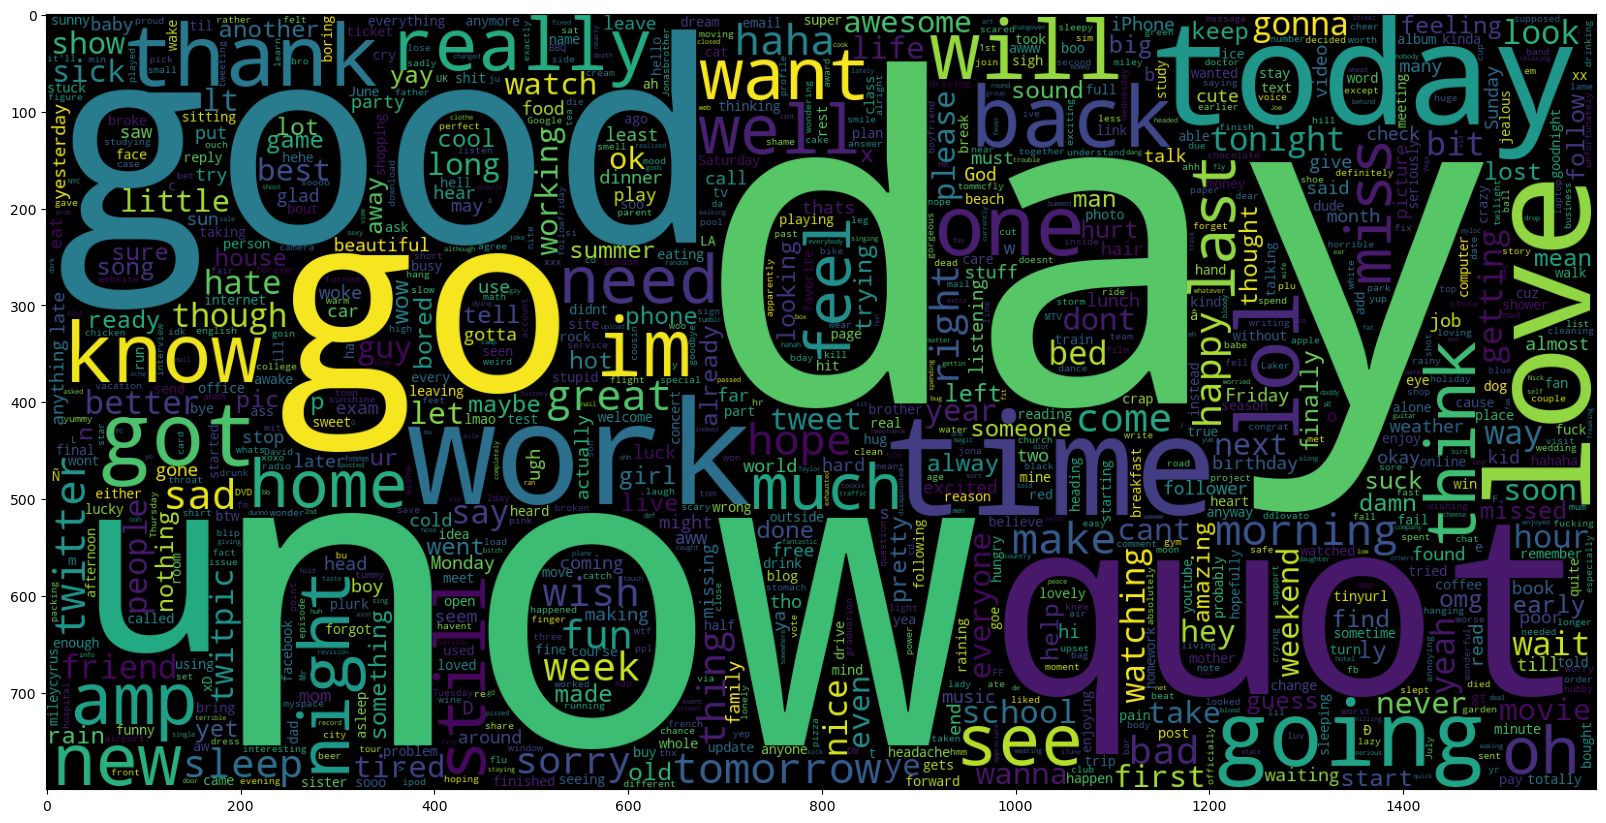

In [35]:
from wordcloud import WordCloud
data_neg = df['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [36]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [37]:
X=df['text']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =42)

In [38]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [39]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [40]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80    159494
           1       0.80      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



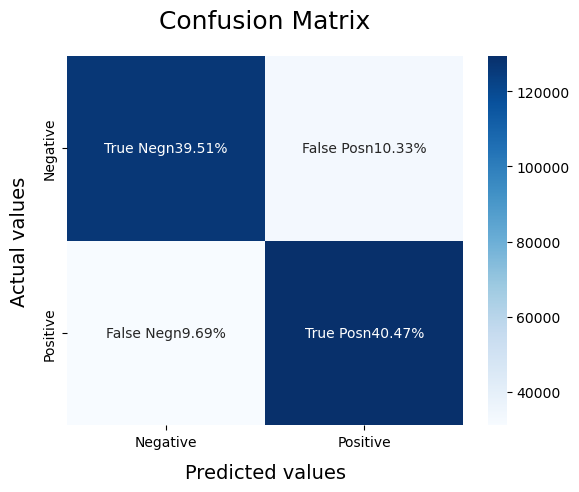

In [41]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159494
           1       0.81      0.82      0.82    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



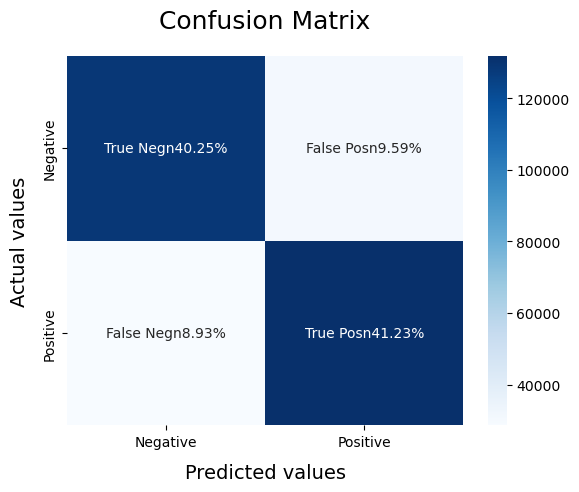

In [42]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159494
           1       0.82      0.83      0.83    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



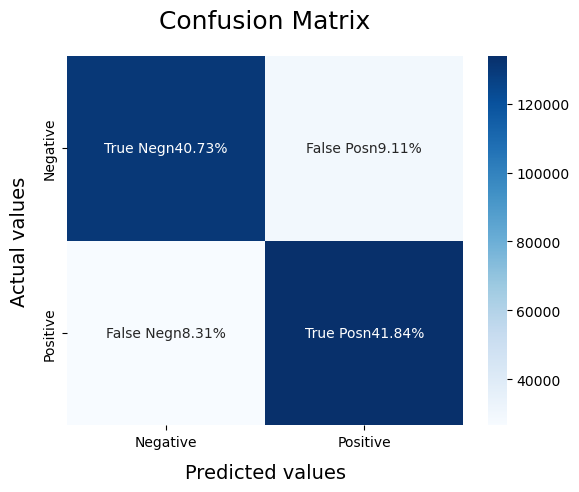

In [43]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [44]:
from sklearn.naive_bayes import ComplementNB

In [45]:
naive_model = ComplementNB().fit(X_train,y_train)

In [46]:
predictions = naive_model.predict(X_test)

In [47]:
from sklearn.metrics import confusion_matrix,classification_report

In [48]:
print(confusion_matrix(predictions,y_test))

[[130823  33749]
 [ 28671 126757]]


In [49]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81    164572
           1       0.79      0.82      0.80    155428

    accuracy                           0.80    320000
   macro avg       0.80      0.81      0.80    320000
weighted avg       0.81      0.80      0.80    320000

